In [ ]:
import os
import sys
import numpy as np
import random
import matplotlib.pyplot as plt

## torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim


import torch.distributed as dist
## Torchvision
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset , random_split
import torchvision.models as models


In [ ]:
DATASET_PATH = "./data"
random.seed(42)
#Device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
project_path = '/content/drive/My Drive/self_supervised_learning'
os.chdir(project_path)

print("Current directory:", os.getcwd())

Current directory: /content/drive/My Drive/self_supervised_learning


In [ ]:
from files.models import *

#### Data Preparation : Partionning & preprocesing

## **MNIST**

 Let's start by downloading the **MNIST** dataset: a very common and large database of grayscale images showing handwritten digits ranging from 0 to 9. It comprises 60,000 training images and 10,000 testing images of size 28x28.


In [ ]:
# Transform to normalized Tensors in the range [0,1]

transform = T.Compose([T.Pad(2) #to cope with the assumption about the "same number of input pixels per image", we choose the input dimension of 32x32 for all datasets. We thus resize all images (originally 28x28) using the padding function "Pad" (add 0 to the borders).
                       , T.ToTensor(), T.Normalize((0.5,), (0.5,))])

In [ ]:
MNIST_train_dataset = MNIST(root=DATASET_PATH, train= True, download=True, transform=transform)
MNIST_test_dataset = MNIST(root=DATASET_PATH, train= False, download=True, transform=transform)

In [ ]:
MNIST_train_dataset, MNIST_test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                Pad(padding=2, fill=0, padding_mode=constant)
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                Pad(padding=2, fill=0, padding_mode=constant)
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ))

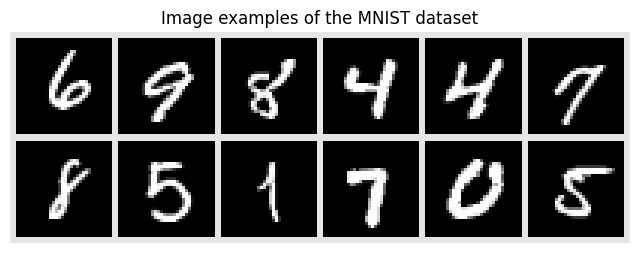

In [ ]:
# Visualize some examples
NUM_IMAGES = 12
MNIST_images = torch.stack([MNIST_train_dataset[np.random.randint(len(MNIST_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [ ]:
# use DataLoader to keep applied transformation when download the data..

MNIST_train_loader = torch.utils.data.DataLoader(MNIST_train_dataset, batch_size=64, shuffle=True)
MNIST_test_loader = torch.utils.data.DataLoader(MNIST_test_dataset, batch_size=64, shuffle=False)
# help(MNIST_train_loader)
#check stats :
data_iter = iter(MNIST_train_loader)
images, labels = next(data_iter)

mean = images.mean()
std = images.std()
min_val = images.min()
max_val = images.max()

print(f'Batch Mean: {mean.item()}')
print(f'Batch Std: {std.item()}')
print(f'Batch Min: {min_val.item()}')
print(f'Batch Max: {max_val.item()}')

Batch Mean: -0.8086686134338379
Batch Std: 0.5371983051300049
Batch Min: -1.0
Batch Max: 1.0


In [ ]:
train_images, train_labels = next(iter(MNIST_train_loader))
print(train_images.shape)
print(train_labels.shape)

torch.Size([64, 1, 32, 32])
torch.Size([64])


### Baseline Model Setup : extent with limited labeled data

In [ ]:
indices = np.random.permutation(len(MNIST_train_dataset))[:100]
train_100= Subset(MNIST_train_dataset, indices)


In [ ]:
train_100_loader = DataLoader(train_100, batch_size=10, shuffle=True)

In [ ]:
image, label = train_100[0]
image.shape, label


(torch.Size([1, 32, 32]), 4)

In [ ]:
model = Basic_CNN()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_100_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_100_loader):.4f}")

Epoch [1/10], Loss: 2.5011
Epoch [2/10], Loss: 1.8189
Epoch [3/10], Loss: 1.1825
Epoch [4/10], Loss: 0.8045
Epoch [5/10], Loss: 0.5511
Epoch [6/10], Loss: 0.3787
Epoch [7/10], Loss: 0.2660
Epoch [8/10], Loss: 0.2021
Epoch [9/10], Loss: 0.1603
Epoch [10/10], Loss: 0.1175


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in MNIST_test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set (10K): {100 * correct / total:.2f}%")

Accuracy on the test set (10K): 77.47%


### Apply MoCo :
workflow : Self-Supervised Pretraining --> Supervised Fine-Tuning --> evaluation

MoCo was implemented on RGB ImageNet data with and ResNet encoder

* modify MoCo loader to handle our data
* configuration (explore light encoder beside resnet(mnist is too simple than imageNet))

In [ ]:
# !git clone https://github.com/facebookresearch/moco.git


fatal: destination path 'moco' already exists and is not an empty directory.


In [ ]:

class MoCo(nn.Module):
    """
    Build a MoCo model with: a query encoder, a key encoder, and a queue.
    https://arxiv.org/abs/1911.05722
    """

    def __init__(self, base_encoder, dim=128, K=65536, m=0.999, T=0.07, mlp=False):
        """
        dim: feature dimension (default: 128)
        K: queue size; number of negative keys (default: 65536)
        m: momentum of updating key encoder (default: 0.999)
        T: softmax temperature (default: 0.07)
        """
        super(MoCo, self).__init__()

        self.K = K
        self.m = m
        self.T = T


        self.encoder_q = base_encoder(num_classes=dim)
        self.encoder_k = base_encoder(num_classes=dim)

        if mlp:
            dim_mlp = self.encoder_q.fc.weight.shape[1]
            self.encoder_q.fc = nn.Sequential(
                nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.encoder_q.fc
            )
            self.encoder_k.fc = nn.Sequential(
                nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.encoder_k.fc
            )

        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False

        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = F.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """
        Momentum update of the key encoder.
        """
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1.0 - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        """
        Dequeue the oldest keys and enqueue the new ones.
        """
        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)
        self.queue[:, ptr:ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.K
        self.queue_ptr[0] = ptr

    def forward(self, im_q, im_k):
        """
        Compute logits and labels for contrastive loss.
        """
        q = self.encoder_q(im_q)
        q = F.normalize(q, dim=1)

        with torch.no_grad():
            self._momentum_update_key_encoder()
            k = self.encoder_k(im_k)
            k = F.normalize(k, dim=1)


        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])
        logits = torch.cat([l_pos, l_neg], dim=1)
        logits /= self.T  #temperature scaling


        labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()


        self._dequeue_and_enqueue(k)

        return logits, labels


In [ ]:
def simple_encoder(num_classes):
    model = models.resnet18(weights=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [ ]:
import sys
sys.path.append(os.path.abspath('./moco'))

print("Python path:", sys.path)

Python path: ['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython', '/tmp/tmp17_bihm3', '/content/drive/MyDrive/self_supervised_learning/moco', '/content/drive/MyDrive/self_supervised_learning/moco', '/content/drive/MyDrive/self_supervised_learning/moco/moco']


In [ ]:
%ls moco


builder.py  __init__.py  loader.py  __pycache__/


In [ ]:
from moco.moco.loader import TwoCropsTransform

In [ ]:
moco_model = MoCo(base_encoder=simple_encoder, dim=128, K=4096, mlp=True)
moco_model = moco_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
batch_size = 8
nb_workers = 2

In [ ]:
base_transform = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.RandomResizedCrop(128, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Apply TwoCropsTransform
Moco_train_transform = TwoCropsTransform(base_transform)

In [ ]:
MNIST_train_dataset = MNIST(root=DATASET_PATH, train=True, download=True, transform=Moco_train_transform)


all_indices = np.arange(len(MNIST_train_dataset))
rest_indices = np.setdiff1d(all_indices, indices) #indices are the 100 indices labeled
train_unlabeled = Subset(MNIST_train_dataset, rest_indices)

train_loader = DataLoader(train_unlabeled, batch_size=batch_size, shuffle=True, num_workers=nb_workers, pin_memory=True)


In [ ]:
for epoch in range(10):
    for images, _ in train_loader:
        # images is a batch of lists, where each list contains [q, k]
        im_q = torch.stack([x[0] for x in images]).cuda()  # Stack and move to GPU
        im_k = torch.stack([x[1] for x in images]).cuda()

        logits, labels = moco_model(im_q, im_k)

        # contrastive loss
        loss = nn.CrossEntropyLoss()(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


Epoch 1, Loss: 8.649298667907715
Epoch 2, Loss: 8.253222465515137
Epoch 3, Loss: 8.280200004577637
Epoch 4, Loss: 8.502165794372559
Epoch 5, Loss: 8.298921585083008
Epoch 6, Loss: 8.337882995605469
Epoch 7, Loss: 8.362114906311035
Epoch 8, Loss: 8.334863662719727
Epoch 9, Loss: 8.432254791259766
Epoch 10, Loss: 8.298063278198242


In [ ]:
# torch.save(moco_model, "/content/drive/My Drive/self_supervised_learning/trained_models/moco_model_10.pth")
# torch.save(moco_model.state_dict(), "/content/drive/My Drive/self_supervised_learning/trained_models/moco_state_dict_10.pth")
# torch.save({
# 'epoch': 10,
# 'model_state_dict': moco_model.state_dict(),
# 'optimizer_state_dict': optimizer.state_dict(),
# }, "/content/drive/My Drive/self_supervised_learning/trained_models/moco_checkpoint_10.pth")

In [ ]:
moco_model = torch.load("/content/drive/My Drive/self_supervised_learning/trained_models/moco_model_10.pth")

<ipython-input-206-b2edf3aa5fc3>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  moco_model = torch.load("/content/drive/My Drive/self_supervised_learning/trained_models/mo

Fine-Tuning : Use the 100 labeled samples to train a classification head on top of the pretrained MoCo encoder

In [ ]:
#reloading data with a simple transform  fct  to fine-tune with consistency ..
labeled_transform = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


MNIST_train_dataset = MNIST(root=DATASET_PATH, train=True, transform=labeled_transform)
train_100 = Subset(MNIST_train_dataset, indices)
train_100_loader = DataLoader(train_100, batch_size=10, shuffle=True)



In [ ]:
for images, _ in train_100_loader:
    print(images.shape)
    break


torch.Size([10, 3, 28, 28])


In [ ]:
for param in moco_model.encoder_q.parameters():
    param.requires_grad = False  # Keep the encoder frozen
for param in moco_model.encoder_q.fc.parameters():
    param.requires_grad = True  # Enable gradients for the classification head

In [ ]:
print(moco_model.encoder_q.fc)


Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=128, bias=True)
)


In [ ]:
# moco_model.encoder_q

In [ ]:
# original_conv1 = moco_model.encoder_q.conv1
# moco_model.encoder_q.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

# moco_model.encoder_q.conv1.weight.data = original_conv1.weight.data.repeat(3, 1, 1, 1) / 3

In [ ]:
print(moco_model.encoder_q.fc)

Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=128, bias=True)
)


In [ ]:
print(moco_model.encoder_q.conv1)
print(moco_model.encoder_q.bn1)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [ ]:
moco_model.encoder_q = moco_model.encoder_q.cuda()


In [ ]:
optimizer = torch.optim.Adam(moco_model.encoder_q.fc.parameters(), lr=0.001)

for epoch in range(10):
    for images, labels in train_100_loader:
        # print(images.shape)  # [batch_size, 3, 28, 28]
        # break
        images, labels = images.cuda(), labels.cuda()

        outputs = moco_model.encoder_q(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Fine-tuning Epoch {epoch + 1}, Loss: {loss.item()}")


Fine-tuning Epoch 1, Loss: 2.4975180625915527
Fine-tuning Epoch 2, Loss: 1.3721848726272583
Fine-tuning Epoch 3, Loss: 1.735158920288086
Fine-tuning Epoch 4, Loss: 0.657180666923523
Fine-tuning Epoch 5, Loss: 0.8256850242614746
Fine-tuning Epoch 6, Loss: 0.24648284912109375
Fine-tuning Epoch 7, Loss: 0.3388679623603821
Fine-tuning Epoch 8, Loss: 0.2687642574310303
Fine-tuning Epoch 9, Loss: 0.18143151700496674
Fine-tuning Epoch 10, Loss: 0.06478115171194077


In [ ]:
MNIST_test_dataset = MNIST(root=DATASET_PATH, train=False, download=True, transform=labeled_transform)
test_loader = DataLoader(MNIST_test_dataset, batch_size=64, shuffle=False)

In [ ]:
test_loader = DataLoader(MNIST(root=DATASET_PATH, train=False, transform=base_transform), batch_size=batch_size)

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = moco_model.encoder_q(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 9.44%
